In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils.segmentation import create_segments
import pickle
import json

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
with open('../Handwritten-Equation-Solver/my_dict.json', 'r') as f:
    mapping = json.load(f)

In [50]:
class CharacterNet(nn.Module):

    ''' CNN architecture for character recognition '''

    def __init__(self):

        super(CharacterNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Sequential(
            nn.Linear(64 * 32 * 32, 2048),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 36)
        )

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 32 * 32)
        x = self.fc(x)
        x = F.softmax(x, dim=1)

        return x
    
model = CharacterNet()
model.load_state_dict(torch.load('AdversarialCharacterNet.pth'))

<All keys matched successfully>

In [78]:
class CharacterNet2(nn.Module):

    ''' CNN architecture for character recognition '''

    def __init__(self):

        super(CharacterNet2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Sequential(
            nn.Linear(64 * 32 * 32, 2048),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 36)
        )

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 32 * 32)
        x = self.fc(x)
        x = F.softmax(x, dim=1)

        return x

model = CharacterNet2()
model.load_state_dict(torch.load('UnscheduledCharacterNet_model.pth'))

<All keys matched successfully>

In [150]:
class CharacterNet22(nn.Module):

    ''' CNN architecture for character recognition '''

    def __init__(self):

        super(CharacterNet22, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc1 = nn.Linear(64*7*7, 512)
        self.fc2 = nn.Linear(512, 36)


    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # x = self.dropout(x)
        # print(x.shape)              # torch.Size([128, 64, 32, 32])
        # x = x.view(-1, 64 * 32 * 32)
        x = x.view(-1, 64*7*7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)

        return x
    
model = CharacterNet22()
model.load_state_dict(torch.load('CharacterNet2.pth'))

<All keys matched successfully>

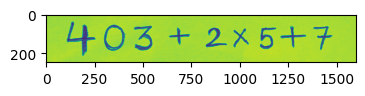

<Figure size 800x200 with 0 Axes>

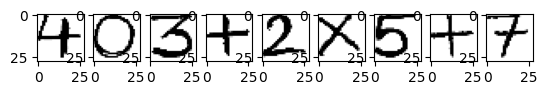

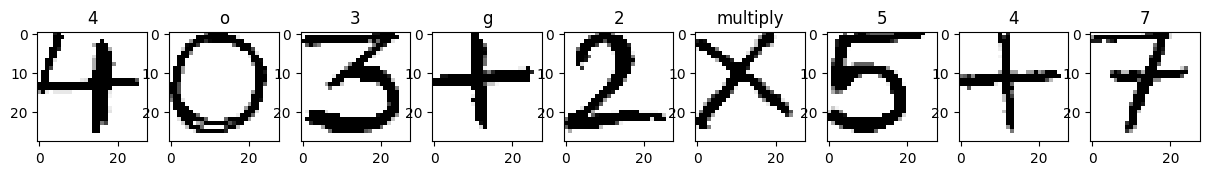

In [152]:
img = cv2.imread('../Handwritten-Equation-Solver/test_data/15.jpeg',cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(4,2))
plt.imshow(img)
plt.show()

segments = create_segments(img)
segments = segments[:len(segments)]
plt.figure(figsize=(8,2))

fig, axes = plt.subplots(1,len(segments))
for i in range(len(segments)):
   
    segments[i] = 255 - segments[i]
    axes[i].imshow(segments[i], cmap='gray')
plt.show()

model = model.to(device)
equation = []

plt.figure(figsize=(15, 3))  # Adjust the figure size as needed

for i, img in enumerate(segments):
    gray_image = cv2.resize(img, (28, 28))
    gray_image = gray_image.reshape((1, 28, 28))
    data = torch.Tensor(np.array([gray_image])).to(device)
    
    output = model(data)
    _, predicted = torch.max(output.data, 1)
    
    plt.subplot(1, len(segments), i + 1)
    plt.imshow(gray_image[0], cmap='gray')
    
    plt.title(mapping[str(predicted.item())])  # Assuming mapping is a dictionary
    
    equation.append(mapping[str(predicted.item())])

plt.show()

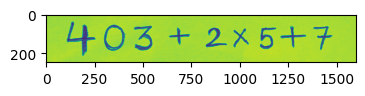

<Figure size 800x200 with 0 Axes>

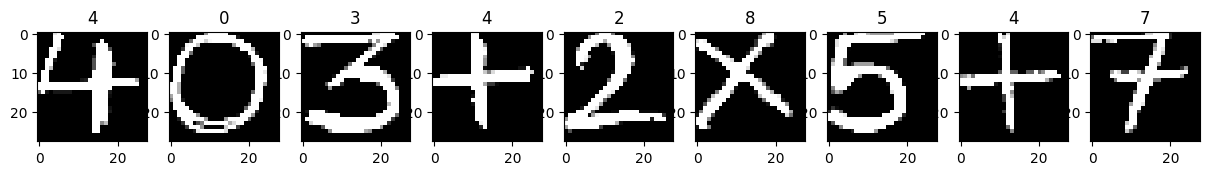

In [154]:
img = cv2.imread('../Handwritten-Equation-Solver/test_data/15.jpeg',cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(4,2))
plt.imshow(img)
plt.show()

segments = create_segments(img)
segments = segments[:len(segments)]
plt.figure(figsize=(8,2))


import matplotlib.pyplot as plt

model = model.to(device)
equation = []


plt.figure(figsize=(15, 3))  # Adjust the figure size as needed

for i, img in enumerate(segments):
    gray_image = cv2.resize(img, (28, 28))
    gray_image = gray_image.reshape((1, 28, 28))
    data = torch.Tensor(np.array([gray_image])).to(device)
    
    output = model(data)
    _, predicted = torch.max(output.data, 1)
    
    plt.subplot(1, len(segments), i + 1)
    plt.imshow(gray_image[0], cmap='gray')
    
    plt.title(mapping[str(predicted.item())])  # Assuming mapping is a dictionary
    
    equation.append(mapping[str(predicted.item())])

plt.show()


In [155]:
symbols = {'add':'+','minus':'-','div':'/', 'left_bracket':'[', 'left_curly_brace':'{', 'left_parenthesis':'(', 'log':'log', 'minus':'-', 'multiply':'*', 'right_bracket':']', 'right_curly_brace':'}', 'right_parenthesis':')', 'sin':'sin', 'slash':'/', 'sqrt':'sqrt', 'summation':'sum', 'tan':'tan'}

eqn = ""
for i in equation:
    if(len(i) > 1):
        eqn += symbols[i]
    else:
        eqn += i
print("Equation = ",eqn)

Equation =  403428547


In [122]:
def evaluate(expression):
    def apply_operator(operators, values):
        operator = operators.pop()
        right = values.pop()
        left = values.pop()
        if operator == '+':
            values.append(left + right)
        elif operator == '-':
            values.append(left - right)
        elif operator == '*':
            values.append(left * right)
        elif operator == '/':
            values.append(left / right)

    def greater_precedence(op1, op2):
        precedences = {'+': 1, '-': 1, '*': 2, '/': 2}
        return precedences[op1] > precedences[op2]

    operators = []
    values = []
    i = 0
    while i < len(expression):
        if expression[i] == ' ':
            i += 1
            continue
        if expression[i] in '0123456789':
            j = i
            while j < len(expression) and expression[j] in '0123456789':
                j += 1
            values.append(int(expression[i:j]))
            i = j
        else:
            if expression[i] == '(':
                operators.append(expression[i])
            elif expression[i] == ')':
                while operators and operators[-1] != '(':
                    apply_operator(operators, values)
                operators.pop()
            else:
                while (operators and operators[-1] != '(' and
                       greater_precedence(operators[-1], expression[i])):
                    apply_operator(operators, values)
                operators.append(expression[i])
            i += 1

    while operators:
        apply_operator(operators, values)

    return values[0]


print("Answer =",evaluate(eqn))

Equation =  87+95
Answer = 182
